In [1]:
import warnings

import pooch

# don't need to show warning about setting up optimizer
warnings.filterwarnings(
    "ignore",
    message="You will need to call setup",
    category=UserWarning,
)

# don't have pooch output messages about downloading or untarring
logger = pooch.get_logger()
logger.setLevel("WARNING")

:::{admonition} Download
:class: important

Download this notebook: **{nb-download}`ps_understand_stats.ipynb`**!

:::

(ps-model-stats)=
# Understanding Portilla-Simoncelli model statistics

The Portilla-Simoncelli consists of a few different classes of statistics:

- Marginal Statistics.  These include pixel statistics (mean, variance, skew, kurtosis, and range of the pixel values), as well as the skewness and kurtosis of the lowpass images computed at each level of the recursive pyramid decomposition.
- Auto-Correlation Statistics.  These include the auto-correlation of the real-valued [steerable pyramid bands](steer-pyr-bands), as well as the auto-correlation of the magnitude of the pyramid bands, and the mean of the magnitude of the pyramid bands.
- Cross-Correlation Statistics.  These include correlations across scale and across orientation bands of the steerable pyramid (both for the real values of the pyramid and for the magnitude of the pyramid bands).

The original paper uses synthesis to demonstrate the role of these different types of statistics.  They show that the statistics can be used to constrain a synthesis optimization to generate new examples of textures.  They also show that the absence of subsets of statistics results in synthesis failures.  Here we replicate those results.

:::{admonition} Reproducing the metamers in this notebook
:class: warning dropdown

Due to pytorch's limitations, we [cannot guarantee perfect reproducibility](reproduce).
However, we've found the setup shown in this notebook works reliably across different images and produce good metamers efficiently.

If you use follow these basic steps and **are not** able to successfully synthesize a good `PortillaSimoncelli` <!-- skip-lint --> model metamer, please post on our [discussion board](https://github.com/plenoptic-org/plenoptic/discussions/) and we'll try to help!

See [](ps-optimization) for more information about the specific decisions taken around optimization, including what "good" means.

:::

In [2]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch

import plenoptic as po

%load_ext autoreload
%autoreload 2

# We need to download some additional images for this notebook.
IMG_PATH = po.data.fetch_data("portilla_simoncelli_images.tar.gz")
CACHE_DIR = po.data.fetch_data("ps_regression.tar.gz")
# use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

# set seed for reproducibility
po.tools.set_seed(1)

:::{admonition} This notebook retrieves cached synthesis results
:class: warning dropdown
This notebook contains many metamers and, while any one synthesis operation does not take too long, all of them combined result in a lengthy notebook. Therefore, instead of performing synthesis in this notebook, we have cached the result of most of these syntheses online and only download them for investigation.

Additionally, while you can normally call {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` again to pick up where we left out, the cached version of the results shown here discarded the optimizer's state dict (to reduce the size on disk). Thus, calling `met.synthesize(100)` with one of our cached and loaded metamer objects **will not** give the same result as calling `met.synthesize(200)` with a new metamer object initialized as shown in this notebook.

:::

In order to do reproduce those results, we create a version of the Portilla Simoncelli model where certain statistics can be turned off. If you are interested in the implementation, see the following dropdown.

In [3]:
# The following class extends the PortillaSimoncelli model so that you can specify
# which statistics you would like to remove.  We have created this model so that we
# can examine the consequences of the absence of specific statistics.


class PortillaSimoncelliRemove(po.simul.PortillaSimoncelli):
    r"""Model for measuring a subset of texture statistics reported by
    PortillaSimoncelli

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model
    remove_keys: list
        The dictionary keys for the statistics we will "remove".  In practice we set
        them to zero.
        Possible keys: ["pixel_statistics", "auto_correlation_magnitude",
        "skew_reconstructed", "kurtosis_reconstructed",
        "auto_correlation_reconstructed", "std_reconstructed", "magnitude_std",
        "cross_orientation_correlation_magnitude", "cross_scale_correlation_magnitude",
        "cross_scale_correlation_real", "var_highpass_residual"]
    """

    def __init__(
        self,
        im_shape,
        remove_keys,
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9)
        self.remove_keys = remove_keys

    def forward(self, image, scales=None):
        r"""Generate Texture Statistics representation of an image with `remove_keys`
        removed.

        Parameters
        ----------
        image : torch.Tensor
            A tensor containing the image to analyze.
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's scales attribute.

        Returns
        -------
        representation: torch.Tensor
            3d tensor of shape (batch, channel, stats) containing the measured texture
            stats.

        """
        # create the representation tensor (with all scales)
        stats_vec = super().forward(image)
        # convert to dict so it's easy to zero out the keys we don't care about
        stats_dict = self.convert_to_dict(stats_vec)
        for kk in self.remove_keys:
            # we zero out the stats (instead of removing them) so that we can use all
            # the various helper functions (plot_representation, convert_to_dict,
            # convert_to_tensor) without any problems
            if isinstance(stats_dict[kk], OrderedDict):
                for key, val in stats_dict[kk].items():
                    stats_dict[kk][key] *= 0
            else:
                stats_dict[kk] *= 0
        # then convert back to tensor and remove any scales we don't want
        # (for coarse-to-fine)
        stats_vec = self.convert_to_tensor(stats_dict)
        if scales is not None:
            stats_vec = self.remove_scales(stats_vec, scales)
        return stats_vec

## Pixel Statistics + Marginal statistics

Beginning with some of the pixel and marginal statistics, we'll demonstrate synthesis both with and without combinations of statistics.

To start, we'll remove the following statistics:

- the pixel statistics: mean, variance, skew, kurtosis, minimum, and maximum of the original image.
- skew and kurtosis on the lowpass images computed at each level of the recursive pyramid.

These statistics play an important role constraining the histogram of pixel intensities to match across the original and synthesized image.

(See figure 3 of {cite:alp}`Portilla2000-param-textur`.)

In [4]:
# which statistics to remove
remove_statistics = [
    "pixel_statistics",
    "skew_reconstructed",
    "kurtosis_reconstructed",
]

# run on fig3a or fig3b to replicate paper
fig_name = "fig3b"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# synthesis with full PortillaSimoncelli model
model = po.simul.PortillaSimoncelli(img.shape[-2:]).to(DEVICE)
loss = po.tools.optim.portilla_simoncelli_loss_factory(model, img)
# to avoid running so many syntheses in this notebook, we load a cached version. see the
# following admonition for how to run this yourself
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-False.pt", map_location=DEVICE)

# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(
    img.shape[-2:], remove_keys=remove_statistics
).to(DEVICE)
loss_remove = po.tools.optim.portilla_simoncelli_loss_factory(model_remove, img)
met_remove = po.synth.Metamer(
    img,
    model_remove,
    loss_function=loss_remove,
)
met_remove.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-True.pt", map_location=DEVICE)

:::{admonition} How to run these syntheses manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_remove -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```

Call the {func}`~plenoptic.synthesize.metamer.Metamer.setup` and {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` methods of `met_remove` with the same arguments.

:::

In the following figure, we can see that not only does the metamer created with all statistics look more like the target image than the one created without the marginal statistics, but its pixel intensity histogram is much more similar to that of the target image.

Text(0.5, 1.0, 'Without marginal statistics')

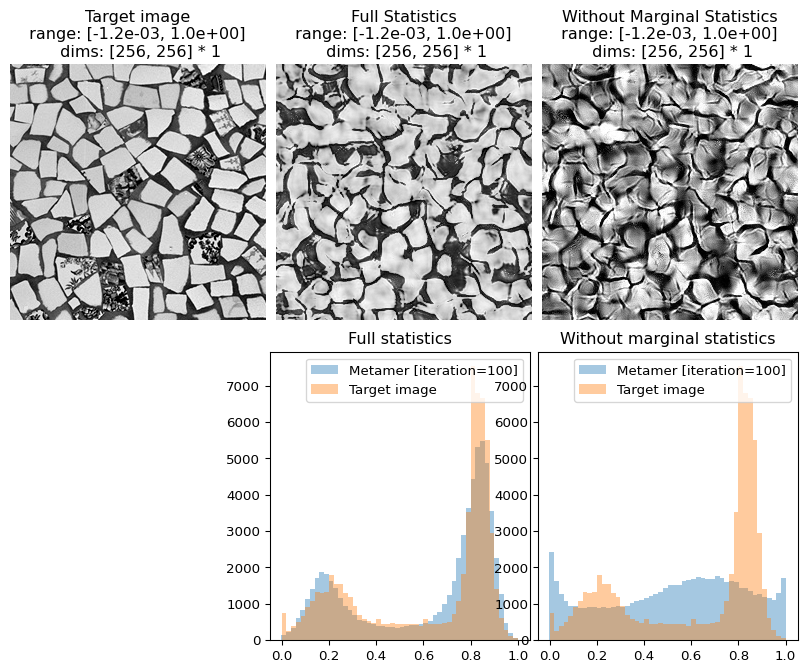

In [5]:
# visualize results
fig = po.imshow(
    [met.image, met.metamer, met_remove.metamer],
    title=["Target image", "Full Statistics", "Without Marginal Statistics"],
    vrange="auto1",
)
# add plots showing the different pixel intensity histograms
fig.add_axes([0.33, -1, 0.33, 0.9])
fig.add_axes([0.67, -1, 0.33, 0.9])
# this helper function expects a metamer object. see the metamer notebook for details.
po.synth.metamer.plot_pixel_values(met, ax=fig.axes[3])
fig.axes[3].set_title("Full statistics")
po.synth.metamer.plot_pixel_values(met_remove, ax=fig.axes[4])
fig.axes[4].set_title("Without marginal statistics")

(ps-coeff-corrs)=
## Coefficient Correlations

In this section, we'll replicate examples of synthesis failures with the following statistics removed:

- local auto-correlations of the lowpass images computed at each level of the recursive pyramid

These statistics play a role in representing periodic structures and long-range correlations. For example, in the image named `fig4b.jpg` (the tile pattern) the absence of these statistics causes results in more difficulty synthesizing the long, continuous lines that stretch from one end of the image to the other.

(See figure 4 of {cite:alp}`Portilla2000-param-textur`.)

In [6]:
# which statistics to remove. note that, in the original paper, std_reconstructed is
# implicitly contained within auto_correlation_reconstructed, view the section on
# differences between plenoptic and matlab implementation for details
remove_statistics = ["auto_correlation_reconstructed", "std_reconstructed"]

# run on fig4a or fig4b to replicate paper
fig_name = "fig4b"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the first section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-False.pt", map_location=DEVICE)

# synthesis with coefficient correlations absent. we have to reinitialize the model and
# the loss because we're removing a different set of statistics.
model_remove = PortillaSimoncelliRemove(
    img.shape[-2:], remove_keys=remove_statistics
).to(DEVICE)
loss_remove = po.tools.optim.portilla_simoncelli_loss_factory(model_remove, img)
met_remove = po.synth.Metamer(
    img,
    model_remove,
    loss_function=loss_remove,
)
met_remove.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-True.pt", map_location=DEVICE)

:::{admonition} How to run these syntheses manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_remove -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```

Call the {func}`~plenoptic.synthesize.metamer.Metamer.setup` and {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` methods of `met_remove` with the same arguments.

:::

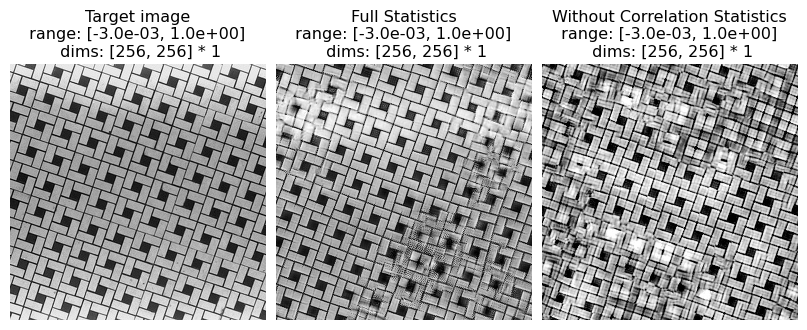

In [7]:
# visualize results
po.imshow(
    [met.image, met.metamer, met_remove.metamer],
    title=[
        "Target image",
        "Full Statistics",
        "Without Correlation Statistics",
    ],
    vrange="auto1",
);

And we can double check the error plots to see the difference in their representations. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the first plot in the middle row in the first figure, especially the center plot, `auto_correlation_reconstructed`, since these statistics are unconstrained for the synthesis done by `met_remove`.

Text(0.5, 0.98, 'Full statistics')

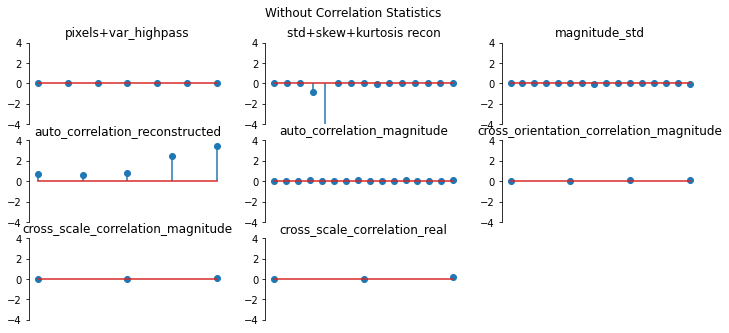

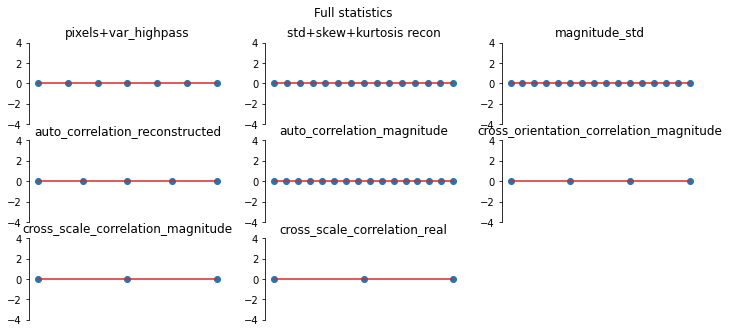

In [8]:
fig, _ = model.plot_representation(
    model(met_remove.metamer) - model(met.image),
    ylim=(-4, 4),
)
fig.suptitle("Without Correlation Statistics")

fig, _ = model.plot_representation(
    model(met.metamer) - model(met.image),
    ylim=(-4, 4),
)
fig.suptitle("Full statistics")

(ps-mag-corrs)=
## Magnitude Correlation

In this section, we'll replicate examples of synthesis failures with the following statistics removed:

- correlation of the complex magnitude of pairs of coefficients at adjacent positions, orientations and scales.

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. For example, in the image named `fig6b.jpg` the absence of these statistics results in a completely different organization of the orientation content in the edges.

(See figure 6 of {cite:alp}`Portilla2000-param-textur`.)

In [9]:
# which statistics to remove. note that, in the original paper, magnitude_std is
# implicitly contained within auto_correlation_magnitude, view the section on
# differences between plenoptic and matlab implementation for details.
remove_statistics = [
    "magnitude_std",
    "cross_orientation_correlation_magnitude",
    "cross_scale_correlation_magnitude",
    "auto_correlation_magnitude",
]

# run on fig6a or fig6b to replicate paper
fig_name = "fig6b"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the previous section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-False.pt", map_location=DEVICE)


# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(
    img.shape[-2:], remove_keys=remove_statistics
).to(DEVICE)
loss_remove = po.tools.optim.portilla_simoncelli_loss_factory(model_remove, img)
met_remove = po.synth.Metamer(
    img,
    model_remove,
    loss_function=loss_remove,
)
met_remove.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-True.pt", map_location=DEVICE)

:::{admonition} How to run these syntheses manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_remove -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```

Call the {func}`~plenoptic.synthesize.metamer.Metamer.setup` and {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` methods of `met_remove` with the same arguments.

:::

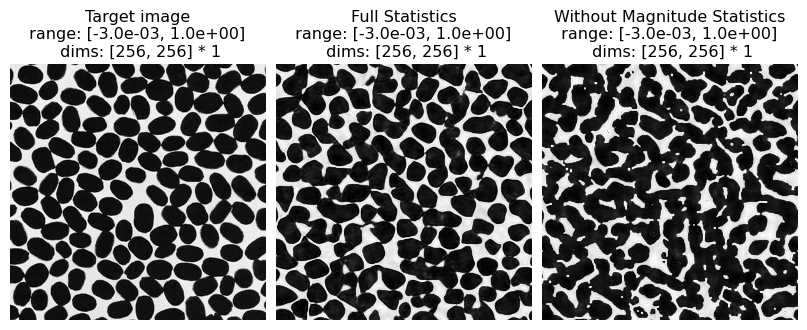

In [10]:
# visualize results
po.imshow(
    [met.image, met.metamer, met_remove.metamer],
    title=["Target image", "Full Statistics", "Without Magnitude Statistics"],
    vrange="auto1",
);

And again, let's look at the error plots. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the plot scorresponding to `auto_correlation_magnitude`, `cross_orientation_correlation_magnitude`, and `cross_scale_correlation_magnitude`., since these statistics are unconstrained for the synthesis done by `met_remove`.

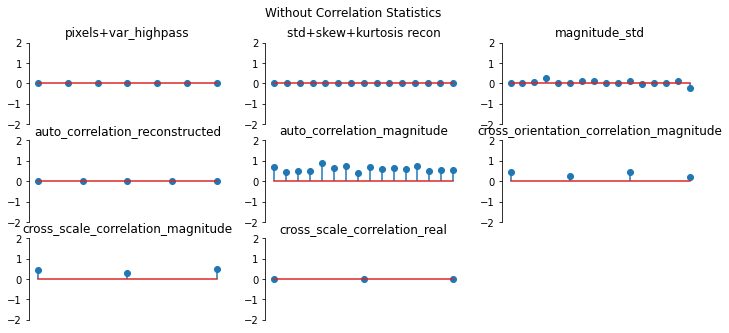

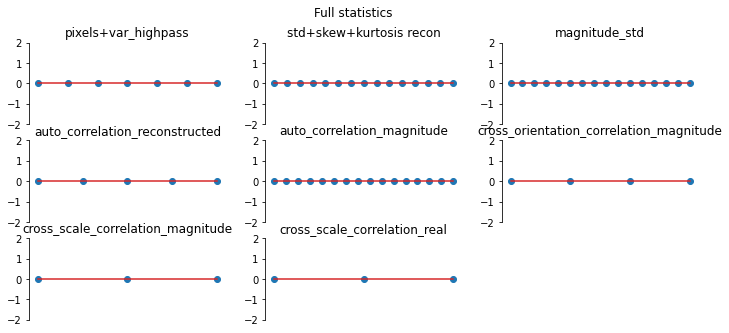

In [11]:
fig, _ = model.plot_representation(
    model(met_remove.metamer) - model(met.image),
    ylim=(-2, 2),
)
fig.suptitle("Without Correlation Statistics")

fig, _ = model.plot_representation(
    model(met.metamer) - model(met.image),
    ylim=(-2, 2),
)
fig.suptitle("Full statistics");

(ps-cross-scale)=
## Cross-scale Phase Statistics

In this section, we'll replicate examples of synthesis failures with the following statistics removed:

- relative phase of coefficients of bands at adjacent scales

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. These phase statistics are important in representing textures with strong illumination effects. When they are removed, the synthesized images appear much less three dimensional and lose the detailed structure of shadows.

(See figure 8 of {cite:alp}`Portilla2000-param-textur`.)

In [12]:
# which statistics to remove
remove_statistics = ["cross_scale_correlation_real"]

# run on fig8a and fig8b to replicate paper
fig_name = "fig8b"
img = po.tools.load_images(IMG_PATH / f"{fig_name}.jpg")
img = img.to(DEVICE).to(torch.float64)

# We reuse the model and loss definition from the first section; the only difference
# is the image.
met = po.synth.Metamer(
    img,
    model,
    loss_function=loss,
)
met.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-False.pt", map_location=DEVICE)

# synthesis with pixel and marginal statistics absent
model_remove = PortillaSimoncelliRemove(
    img.shape[-2:], remove_keys=remove_statistics
).to(DEVICE)
loss_remove = po.tools.optim.portilla_simoncelli_loss_factory(model_remove, img)
met_remove = po.synth.Metamer(
    img,
    model_remove,
    loss_function=loss_remove,
)
met_remove.load(CACHE_DIR / f"ps_remove_{fig_name}_remove-True.pt", map_location=DEVICE)

:::{admonition} How to run these syntheses manually
:class: dropdown note

<!-- TestPortillaSimoncelli.test_ps_remove -->
```{code-block} python
opt_kwargs = {
    "max_iter": 10,
    "max_eval": 10,
    "history_size": 100,
    "line_search_fn": "strong_wolfe",
    "lr": 1,
}
met.setup(optimizer=torch.optim.LBFGS, optimizer_kwargs=opt_kwargs)
met.synthesize(max_iter=100)
```

Call the {func}`~plenoptic.synthesize.metamer.Metamer.setup` and {func}`~plenoptic.synthesize.metamer.Metamer.synthesize` methods of `met_remove` with the same arguments.

:::

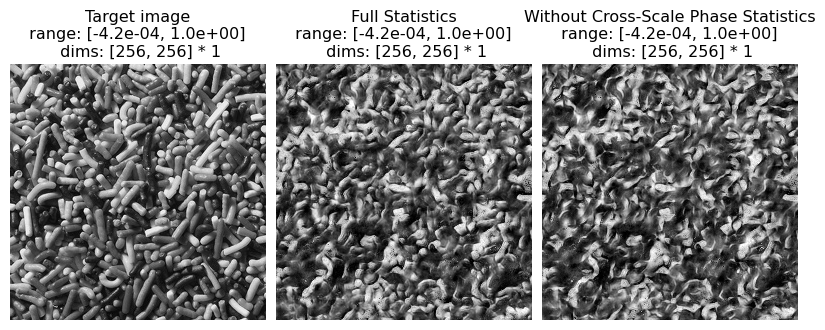

In [13]:
# visualize results
po.imshow(
    [met.image, met.metamer, met_remove.metamer],
    title=[
        "Target image",
        "Full Statistics",
        "Without Cross-Scale Phase Statistics",
    ],
    vrange="auto1",
);

And again, let's look at the error plots. The first figure shows the error for the metamer created without the correlation statistics (at right above), while the second shows the error for the metamer created with all statistics (center), and we can see that larger error in the final plot in the first figure, `cross_scale_correlation_real`, since these statistics are unconstrained for the synthesis done by `metamer_remove`.

Text(0.5, 0.98, 'Full statistics')

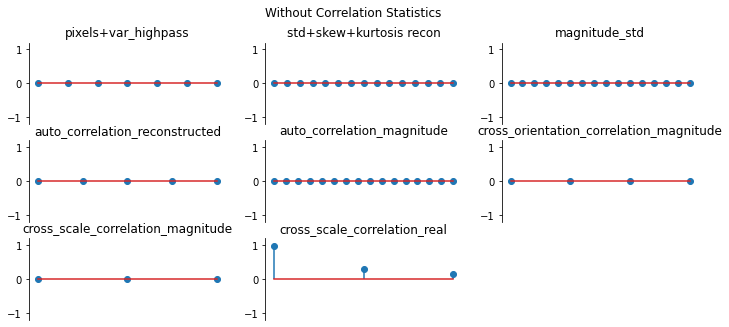

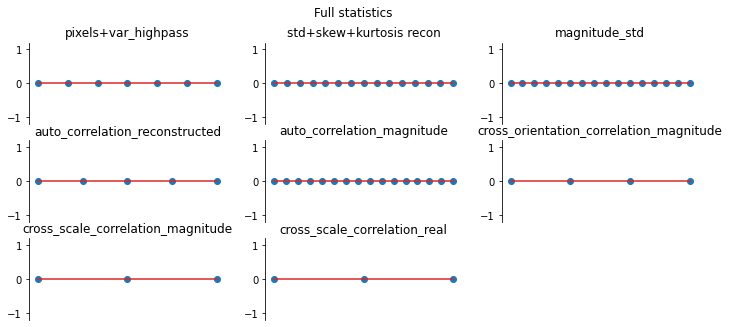

In [14]:
fig, _ = model.plot_representation(
    model(met_remove.metamer) - model(met.image),
    ylim=(-1.2, 1.2),
)
fig.suptitle("Without Correlation Statistics")

fig, _ = model.plot_representation(
    model(met.metamer) - model(met.image),
    ylim=(-1.2, 1.2),
)
fig.suptitle("Full statistics")

## Further reading

- To see more texture model metamers with different types of images, see the [](ps-examples) notebook.
- To learn more about the optimization choices, read the [](ps-optimization) notebook.